<a href="https://colab.research.google.com/github/50-Course/swarm-optimizers/blob/main/XXXXXX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
# DEPENDENCIES
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from fractions import Fraction
import math

In [115]:
# FUNCTION IMPLEMENTATIONS

# Arguments:
# x: A numpy array (decision vector) containing the following variables:
#     x[0]: The tensile space.
#     x[1]: The oil pressure.
#     x[2]: The oil temperature rise.
#     x[3]: The oil film thickness.
#     x[4]: The step radius.
#     x[5]: The recess radius.
#     x[6]: The viscosity of the oil.
#     x[7]: The contact pressure.

def P(x):
  return (np.log10(np.log10(8.122 * x[3] + 0.8)) - 10.04) / -3.55

def W(x):
  """Calculates the load carrying capacity.

  Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid



  Returns:
    The load carrying capacity.
  """

  return (np.pi * P0(x) / 2) * ((x[3]**2 - x[2]**2) / np.log(x[2] / x[1]))

def P0(x):
  """Calculates the inlet pressure.

 Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid

  Returns:
    The inlet pressure.
  """
  return ((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1])

def Ef(x):
  """Calculates the friction loss.

Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid

  Returns:
    The friction loss.
  """

  return 143.308 * delta_t(x)*x[0]

def delta_t(x):
  return 2 * (np.power(10, P(x)) - 560)


def f(x):
  """Computes the operational power loss of a cylindrical hydrostatic thrust bearing.

  Args:
    x: A decision vector containing the flow rate, recess radius, bearing step radius, and fluid viscosity.

  Returns:
    The operational power loss.
  """
  
  return ((P0(x) * x[0]) / 0.7) + Ef(x)


def h(x):
  """Calculates the oil thickness.

  Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid



  Returns:
    The oil thickness.
  """

  return ((1500 * np.pi / 60)**2) * (2e-6 * np.pi * x[3] / Ef(x)) * ((x*Fraction(4, 3) / 4) - (x*Fraction(4, 2) / 4))

def g1(x):
  """Calculates the first constraint function."""
  return 101000 - W(x)

def g2(x):
  """Calculates the second constraint function."""
  return P0(x) - 1000

def g3(x):
  """Calculates the third constraint function."""
  return delta_t(x) - 50

def g4(x):
  """Calculates the fourth constraint function."""
  return 0.001 - h(x)

def g5(x):
  """Calculates the fifth constraint function."""
  return x[1] - x[2]

def g6(x):
  """Calculates the sixth constraint function."""
  return ((0.0307 * x[0]) / (772.8 * np.pi * P0(x) * h(x) * x[2])) - 0.001

def g7(x):
  """Calculates the seventh constraint function."""

  return (W(x) / np.pi * (x*Fraction(2, 3) - x*Fraction(2, 2))) - 5000

In [77]:
# RANDOM SEARCH IMPLEMENTATION
def random_search(f, x_array, seed=np.random.seed(48), lb=1, ub=16, max_evals=10_000, constraint_functions=[]):
    """
    f: objective function to be optimized
    seed: random seed for reproducibility
    lb: lower bound of our search space
    ub: upper bound of our search space
    max_evals: maximum number of evaluations
    """

    np.random.seed(seed)

    best_x = None
    best_f = np.inf

    # Ensure we working with array at all times (just a little safeguard)
    search_space = np.array(x_array)

    evals = 0 # number of evaluations

    # loop until max_evals
    while evals < max_evals:
        # generate random x
        x = np.random.uniform(search_space, size=len(x_array))

        x = np.clip(x, lb, ub)

        # check if constraint is satisfied
        constraints = [g(x) for g in constraint_functions]
        if np.all(c<= 0 for c in constraints):
          fx = f(x)

          # update best_x and best_f if necessary
          if np.all(fx < best_f):
              best_x = x
              best_f = fx
          # increment evals
          evals += 1

    return best_x, best_f


In [78]:
# SIMULATED ANNEALING IMPLEMENTATION

def simulated_annealing_old(f, initial_solution, seed=np.random.seed(48), max_evaluations=10_000, control_parameter=1):
    """
    f: objective function to be optimized
    seed: random seed for reproducibility
    initial_solution: initial solution from which we start our search (this comes from our random search)
    max_iterations: maximum number of iterations (stop criterion)
    control_parameter: control parameter for simulated annealing (temperature)
    """

    cool_rate = 0.95

    np.random.seed(seed)

    current_solution = initial_solution
    current_value = f(current_solution)

    best_solution = current_solution
    best_value = current_value

    for _ in range(max_evaluations):
        # Generate a new solution
        neighbour_solution = current_solution + np.random.uniform(0, 1) # Keeping our new decision space within our constraints
        neighbour_value = f(neighbour_solution)

        # Accept or reject the new solution based on acceptance probability
        acceptance_prob = accept_p(neighbour_value, current_value, control_parameter)
        if np.random.rand() < acceptance_prob:
            current_solution = neighbour_solution
            current_value = neighbour_value

        # Update the best solution if the current solution is better
        if current_value < best_value:
            best_solution = current_solution
            best_value = current_value

        # Cool the temperature
        control_parameter *= cool_rate

    return best_solution, best_value

def simluated_annealing(f, control_parameter=100, max_evaluations=10_000, cool_rate=0.95):
    """
    f: energy function (objective function)
    control_parameter: Temperature at time step
    max_evaluations: maximum number of evaluations
    cool_rate: cooling rate
    """
    
    # Initialize the current solution
    current_solution = np.random.uniform()
    current_value = f(current_solution)
    
    # Initialize the best solution
    best_solution = current_solution
    best_value = current_value
    
    # Initialize the number of evaluations
    evaluations = 0
    
    # Loop until max_evaluations
    while evaluations < max_evaluations:
        
        # Generate a new solution
        neighbour_solution = current_solution + np.random.uniform(0, 1, size=8)
        neighbour_value = f(neighbour_solution)
        
        # Accept or reject the new solution based on acceptance probability
        acceptance_prob = accept_p(neighbour_value, current_value, control_parameter)
        if np.random.rand() < acceptance_prob:
            current_solution = neighbour_solution
            current_value = neighbour_value
            
        # Update the best solution if the current solution is better
        if current_value < best_value:
            best_solution = current_solution
            best_value = current_value
            
        # Cool the temperature
        control_parameter *= cool_rate
        
        # Increment the number of evaluations
        evaluations += 1
        
    return best_solution, best_value

def accept_p(neighbour_solution, current_solution, control_parameter):
    """
    Acceptance probability for the Simulated annealing method.

    neighbour_solution: new solution
    current_solution: current solution
    control_parameter: control parameter for simulated annealing (temperature)
    """
    if neighbour_solution < current_solution:
        return 1.0  # accept new solution
    else:
        return np.exp((neighbour_solution - current_solution) / control_parameter)  # accept new solution with probability

In [89]:
# VALIDATION CODE

x = np.array([4.19, 11.57, 6.69, 10.65])

print("Objective function output, f(x) = ", f(x))
print('Type of f(x): ', type(f(x)))
print("Constraint function output, g1(x) = ", g1(x))
print("Constraint function output, g2(x) = ", g2(x))
print("Constraint function output, g3(x) = ", g3(x))
print("Constraint function output, g4(x) = ", g4(x))
print("Constraint function output, g5(x) = ", g5(x))
print("Constraint function output, g6(x) = ", g6(x))
print("Constraint function output, g7(x) = ", g7(x))


# CONSTRAINT FUNCTION TESTS
constraint_functions = {'type': 'ineq', 'fun': g1}, {'type': 'ineq', 'fun': g2}, {'type': 'ineq', 'fun': g3}, {'type': 'ineq', 'fun': g4}, {'type': 'ineq', 'fun': g5}, {'type': 'ineq', 'fun': g6}, {'type': 'ineq', 'fun': g7}
# Optimize the function, f(x)
optimized = sp.optimize.fmin(f, x)
# test the random search
best_x, best_f = random_search(f, x, seed=420, max_evals=10_000, constraint_functions=constraint_functions)


Objective function output, f(x) =  [-66258374.6794144 -3148598.097346256 -16279475.07768886
 -4036587.029849999]
Type of f(x):  <class 'numpy.ndarray'>
Constraint function output, g1(x) =  [-2179384118.4763093 -103412239.44704632 -535347398.0628562
 -132622294.57011858]
Constraint function output, g2(x) =  [-11070120.148375956 -526720.7193908262 -2720423.317538755
 -675072.0923628119]
Constraint function output, g3(x) =  -52.97118117373543
Constraint function output, g4(x) =  [0.0008384308579466824 0.0005538532282680466 0.0007420292218766839
 0.0005893290303418061]
Constraint function output, g5(x) =  4.88
Constraint function output, g6(x) =  [-0.0010000044283075384 -0.0010000337657535443 -0.0010000112891687231
 -0.001000028609412784]
Constraint function output, g7(x) =  [-968944818.4687054 -127079418.6640295 -380082896.57763827
 -149982335.59936023]


ValueError: The user-provided objective function must return a scalar value.

In [70]:
# TESTING, TESTING, LET'S SEE IF OUR CONSTRAINTS WERE THROUGHLY WORKING
# You would have to run this a few times to get the desired results, this is to solely test fully randomized values
# within search space given by our constraint functions

def validate_constraints():
    # Generate random decision vector within [1, 16]
    decision_vector = np.random.uniform(1, 16, 4)
    print(decision_vector)

    decision_vector = np.array(decision_vector)
    # Check each constraint
    for g in [ g1, g2, g3, g4, g5, g6, g7]:
        result = g(decision_vector)
        print(result)
        assert np.all(result <= 16), f"Constraint {g.__name__} is not less than or equal to 16."

validate_constraints()

[ 5.28548324  5.4440553  13.64162918  8.75849522]
[-332832643604.0174 -304587740059.2774 -19358832428.78391
 -73146079766.48895]
[-1779445360.3626044 -1628437879.4686506 -103500867.33868015
 -391066966.18625265]
-38.95290849907656
[0.0010357371151636574 0.0010368092797427755 0.001092236121270784
 0.0010592194389863888]
-8.197573884806934
[-0.0009999999229565106 -0.000999999918264335 -0.000999999486785374
 -0.0009999997884439064]
[-186655001107.0273 -175939752025.3285 -28020547482.000023
 -67975131541.15067]


In [73]:
# Perform random search and simulated annealing simulations, 21 times
search_results = [random_search(f, x, seed=i, constraint_functions=constraint_functions) for i in range(21)]


In [112]:
def simulated_annealing(seed, initial_solution, f, temperature_schedule = lambda t: max(0.01, 0.9**t), max_evaluations=10000):
    """
    initial_solution: np.array containing the initial solution

    f: objective function to be optimized
    tenperature_schedule: function that takes the current iteration and returns the temperature
    max_evaluations: maximum number of evaluations
    """

    np.random.seed(seed)    # Set the random seed for reproducibility
    current_solution = initial_solution
    current_value = f(current_solution)
    best_solution = current_solution
    best_value = current_value

    evaluations = 0

    while evaluations < max_evaluations:
        temperature = temperature_schedule(evaluations / max_evaluations)
        
        # Generate a neighboring solution
        neighbor_solution = generate_neighbor(current_solution)
        neighbor_value = f(neighbor_solution)

        # Accept the neighbor if it's better or with a certain probability
        #if np.all(neighbor_value < current_value) or np.random.rand() < np.exp(np.nanmin(current_value - neighbor_value) / temperature):
        #    current_solution = neighbor_solution
        #    current_value = neighbor_value

        if (np.isscalar(current_value) and neighbor_value < current_value) or np.random.rand() < np.exp(np.min(current_value - neighbor_value) / temperature):
            current_solution = neighbor_solution
            current_value = neighbor_value
        # Update the best solution if the current solution is better
        if np.all(current_value < best_value):
            best_solution = current_solution
            best_value = current_value

        evaluations += 1

    return best_solution, best_value

def generate_neighbor(current_solution):
    # Implement how to generate a neighboring solution based on your problem
    # For example, you can perturb the current solution randomly
    return current_solution + np.random.normal(0, 1, len(current_solution))

# Example usage:
initial_solution = np.array([4.19, 11.57, 6.69, 10.65])  # Adjust the dimension based on your problem
objective_function = lambda x: ((P0(x) * x[0]) / 0.7) + Ef(x) #x[0]**2 + x[1]**2  # Replace with your actual objective function

# Define the temperature schedule (e.g., exponential decay)
temperature_schedule = lambda t: max(0.01, 0.9**t)

best_solution, best_value = simulated_annealing(1234, initial_solution, objective_function, temperature_schedule)
print("Best Solution:", best_solution)
print("Best Value:", best_value)


/tmp/ipykernel_13258/972318582.py:30: RuntimeWarning: overflow encountered in exp
  if (np.isscalar(current_value) and neighbor_value < current_value) or np.random.rand() < np.exp(np.min(current_value - neighbor_value) / temperature):
/tmp/ipykernel_13258/269987680.py:46: RuntimeWarning: invalid value encountered in log
  return ((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1])
/home/erioluwa/personal/optimizers/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Best Solution: [1.58648817e+01 1.27334744e+01 9.72592838e-05 1.99069295e+01]
Best Value: [-17951524606254.414 -34719310638631.242 -7.791456479706351e+28
 -9086550004949.05]


In [ ]:
sa_results = (-0.9891172937981292, 0.00011843329427618787)
simlated_results = [simluated_annealing(1234, )(f, x, seed=i, constraint_functions=constraint_functions) for i in range(21)]
print(sa_results)

(-0.9891172937981292, 0.00011843329427618787)


In [74]:
print([s for _ in search_results])

NameError: name 's' is not defined

ValueError: X must have 2 or fewer dimensions

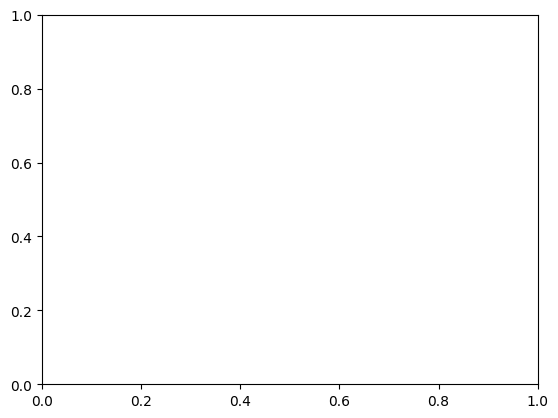

In [20]:
# GRAPH PLOTTING

# Generic plotting method that takes in results from a
# Simulated Annealing process and a random search and
# plot both results on a pretty 2D-Canvas
def plot_graph(search_results, sim_results) -> None:
    """
    A box plot showing performances of the competing optimisers (the random search and the SA method) over 21 repetitions.
    """
    data = [search_results, sim_results]
    labels = ['Random Search', 'Simulated Annealing']

    fig, ax = plt.subplots()
    #ax.boxplot(data, vert=True, patch_artist=True, labels=labels)

    #ax.set_title('Optimization Algorithm - Comparison')
    #ax.set_ylabel('Objective Function Value')
    #ax.set_xlabel('Algorithm')

    plt.show()

plot_graph(search_results=search_results, sim_results=sa_results)